In [1]:
import time
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

    except RuntimeError as error:
        # Memory growth must be set before GPUs have been initialized
        print(error)

In [3]:
def load_img(path_to_img):
    max_dim = 512

    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    scale = max_dim / max(shape)
    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)

    # in order to use CNN, add one additional dimension to the original image
    # img shape: [height, width, channel] -> [batch_size, height, width, channel]
    img = img[tf.newaxis, :]
    
    return img

In [4]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    if title:
        plt.title(title)

    plt.imshow(image)

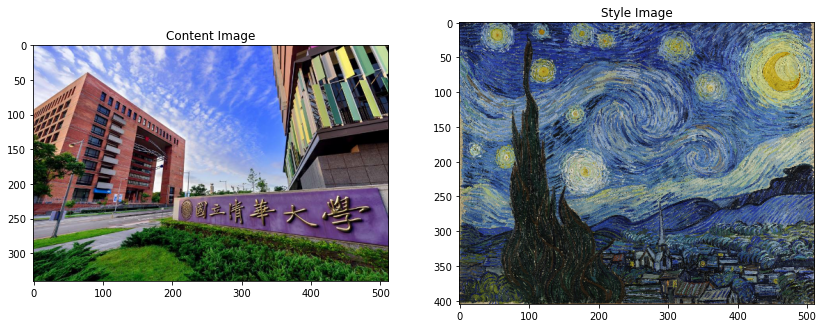

In [5]:
content_path = './dataset/content.jpg'
style_path = './dataset/style.jpg'

content_image = load_img(content_path)
style_image = load_img(style_path)

plt.figure(figsize=(14,10))

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [7]:
# Content layer where will pull our feature maps
content_layers = ['block1_conv1',
                  'block2_conv1',
                  'block3_conv1',
                  'block4_conv1',
                  'block5_conv1'] 

# Style layer of interest
style_layers = ['block1_conv2',
                'block2_conv2',
                'block3_conv2', 
                'block4_conv2', 
                'block5_conv2']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [8]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    model = tf.keras.Model([vgg.input], [vgg.get_layer(name).output for name in layer_names])

    return model

In [9]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image * 255)

In [10]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / num_locations

In [11]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.vgg.trainable = False

        self.style_layers = style_layers
        self.num_style_layers = len(style_layers)

        self.content_layers = content_layers

    def call(self, inputs):
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)

        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], outputs[self.num_style_layers:])
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
        style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

In [12]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))
style_results = results['style']

In [13]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    style_loss = tf.add_n(
        [tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2) 
        for name in style_outputs.keys()]
    )
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n(
        [tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
        for name in content_outputs.keys()]
    )
    content_loss *= content_weight / num_content_layers

    loss = style_loss + content_loss
    return loss

In [14]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [15]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    # tape.gradient: d_loss/d_image
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [16]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

image = tf.Variable(content_image)
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_weight = 0.3
content_weight = 100.0

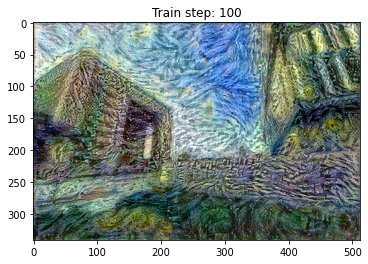

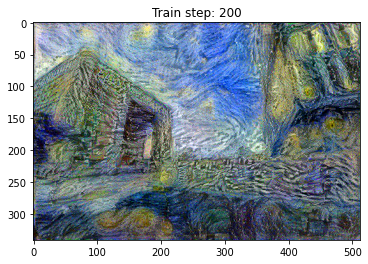

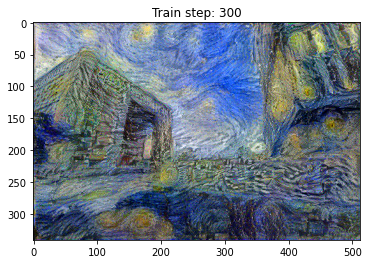

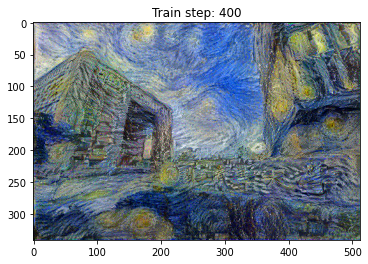

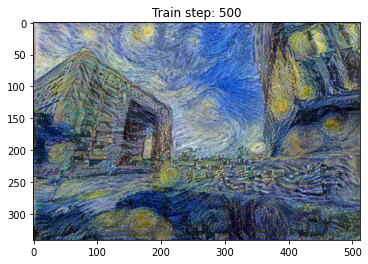

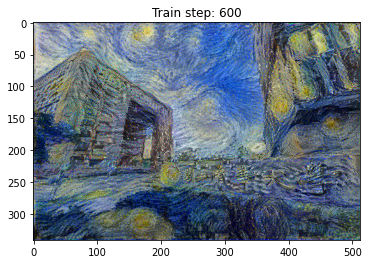

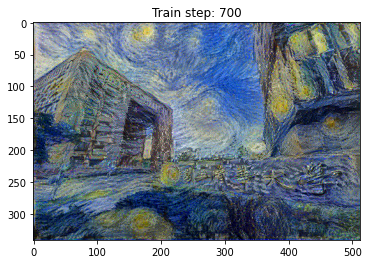

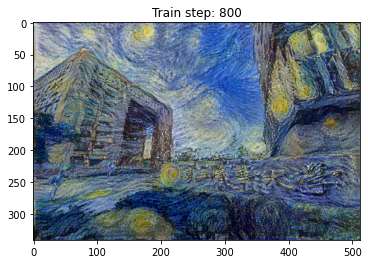

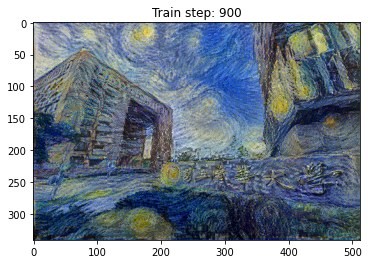

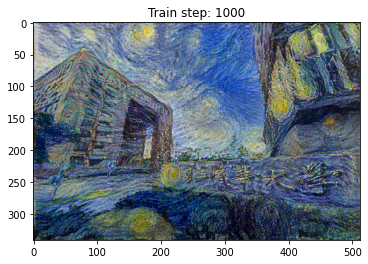

Total time: 72.2


In [19]:
start = time.time()

step = 0
epochs = 10
steps_per_epoch = 100

for _ in range(epochs):
    for _ in range(steps_per_epoch):
        step += 1
        train_step(image)

    imshow(image.read_value())
    plt.title("Train step: {}".format(step))
    plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))

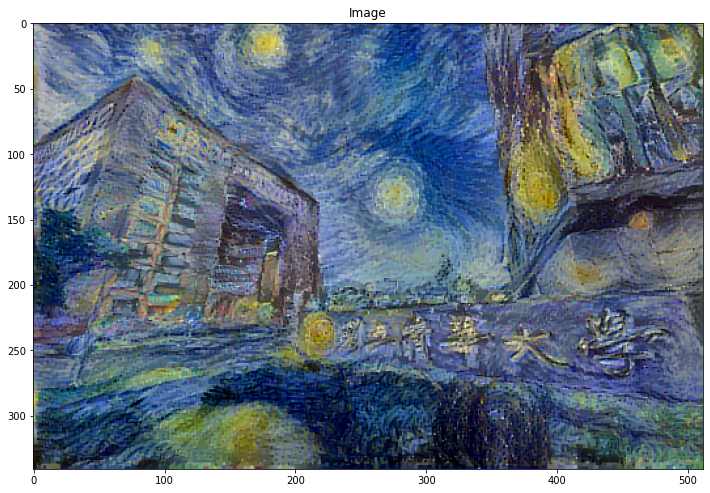

In [40]:
plt.figure(figsize=(12,12))
imshow(image, 'Image')